# Background
iRobot has a series of wifi-connected robotic vacuum cleaners available for sale worldwide. These robots are capable of autonomously navigating a home to vacuum its floors. Upon mission completion, they send a summary report of the mission to cloud services, where it is processed and stored as a row in a Postgres database. However, any cleaning mission performed while the robot is not connected to wifi (either by user's choice or a faulty connection) will not be saved in the database. In addition, there are occasional periods where cloud services malfunction and no missions are reported, resulting in discrete periods of data loss.

These robots are programmed with an automatic recharge and resume function, which means that when the robot detects its battery levels reaching critically low levels, it will navigate back to the charging dock if available and charge for up to 90 minutes before resuming the mission. In addition, if a robot becomes stuck on an obstacle in its environment or is manually paused by a button press, it will cease cleaning for up to 90 minutes before terminating the mission. If the user restarts the mission with a button press within 90 minutes of the pause, the robot will continue cleaning normally. The number of minutes spent cleaning, charging, or paused are reported for each mission, as is the mission outcome (a field describing whether the mission was cancelled, the robot got stuck, the battery died, or the robot completed the job successfully).

# Data
1. mission_data.csv.bz2
This table contains details of cleaning missions for a sample of 10,000 wifi-connected robots
The columns are defined as follows:
 * **robotid**: a unique robot identifier
 * **datetime**: a date string that represents the start time of a mission in GMT
 * **nmssn**: mission number. This information comes from an internal counter on the robot that increments +1 per mission. Be aware that the complete mission history from mission 1 may not be included for each robot (due to missions being run before the robot was connected to wifi or data loss). The max mission number per robot should reflect its total number of missions to date reported to the database.
 * **runm**: this is the time in minutes that the robot spent actually cleaning.
 * **chrgm**: this is the time in minutes that a robot spent charging.
 * **pausem**: this is the time in minutes that a robot spent paused.
 * **outcome**: this is the end status of a mission. "Cncl" indicates that the mission was cancelled by the user. "Stuck" means the robot got stuck on an obstacle, and was not rescued within 90 minutes, so could not return to the dock. "Bat" means the robot's battery grew too low for it to return to the dock. "Ok" means the robot successfully completed cleaning the space and returned to the dock.

2. geo_data.csv.bz2
This table contains details of the robot's geographic location.
The columns are defined as follows:
 * **robotid**: unique robot identifier
 * **country_cd**: 2-letter ISO country code
 * **timezone**: robot's timezone (from IANA/Olson database)

# Tasks
Perform data analysis exploring use patterns of the typical robot user per country. Include relevant visualizations where appropriate, and address any possible effects of data loss on your findings.
1. Are there geographic differences in robot usage?
  - Consider all descriptive features of a mission, including when and how frequently it occurred.
  - If applicable, comment on how trends in these features might impact design decisions for the hardware, battery, or navigation algorithms of robots sold in different regions.
2. Calculate the time between consecutive missions for each robot ("inter-mission interval" or "IMI"). Describe any interesting relationships between IMI and other features of robot behavior.
3. **BONUS**: We are aware that data loss exists among the mission records, but are unsure of the cause. Quantify the extent of the loss, differentiating between discrete catastrophic events and random mission loss for individual robots. Investigate whether this loss is uniform or whether it may be impacting other analyses.

# Tools and Submission
Python is preferred, but you may use R or another tool that best demonstrates your skills. You are welcome to use any Python libraries you want. Your final submission should be a single document, either a Jupyter notebook with inline figures or a PDF that includes both write-ups and figures. Be sure to describe your hypotheses, methods, reasoning, and findings (including null findings) in addition to the code required to answer each question. You should expect this task to take 4-5 hours.


In [1]:
# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

# Importing python libraries for data analysis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import researchpy as rp

# Display max rows and columns = 250
pd.set_option('display.max_rows', 250)
pd.set_option('display.max_columns', 250)

In [2]:
# mission_data
mission_df = pd.read_csv('mission_data.csv')
mission_df.head(10)

,robotid,datetime,nmssn,runm,chrgm,pausem,outcome
0,000NG2FMLJBT9ANZ,10/1/17 16:17,40,3,1,2,stuck
1,000NG2FMLJBT9ANZ,10/3/17 14:25,41,83,0,13,ok
2,000NG2FMLJBT9ANZ,10/4/17 12:32,42,66,13,12,ok
3,000NG2FMLJBT9ANZ,10/26/17 2:12,45,72,24,0,cncl
4,000NG2FMLJBT9ANZ,10/27/17 7:17,46,61,9,0,cncl
5,000Y9NBMJ77LQ7S7,11/28/16 5:41,55,61,0,13,ok
6,000Y9NBMJ77LQ7S7,12/20/16 10:06,56,31,0,6,cncl
7,000Y9NBMJ77LQ7S7,2/18/17 3:16,57,11,0,2,cncl
8,000Y9NBMJ77LQ7S7,3/8/17 10:49,58,78,0,0,ok
9,000Y9NBMJ77LQ7S7,3/19/17 10:21,59,99,0,0,cncl


In [3]:
# geo_data
geodata_df = pd.read_csv('geo_data.csv')
geodata_df.head(10)

,country_cd,timezone,robotid
0,SE,Europe/Stockholm,T29NF13ZIYISNF79
1,JP,Asia/Tokyo,9S12V26O6G426OYR
2,IL,Asia/Jerusalem,QI6X3P9JKNILKKU1
3,IL,Asia/Jerusalem,7OMKNWMWA4XWC911
4,IL,Asia/Jerusalem,YO63CL0ZFK83SYCZ
5,DK,Europe/Copenhagen,Y22RZBDPEXT64LWL
6,IL,Asia/Jerusalem,M8B8VIPZDDDWLJ3D
7,IL,Asia/Jerusalem,9C4NPS3Q3N253PIY
8,IL,Asia/Jerusalem,TMMI6I31JH1FLJLG
9,JP,Asia/Tokyo,CSDOPIZNFG5QX3BE


In [4]:
# Outer Join between mission_df and geodata_df - Here all robots are present i.e whose missions have been recorded in database and those whose missions have been not recorded
robotmission_df = pd.merge(mission_df,geodata_df,on='robotid',how='outer')
robotmission_df.head(10)

,robotid,datetime,nmssn,runm,chrgm,pausem,outcome,country_cd,timezone
0,000NG2FMLJBT9ANZ,10/1/17 16:17,40.0,3.0,1.0,2.0,stuck,IL,Asia/Jerusalem
1,000NG2FMLJBT9ANZ,10/3/17 14:25,41.0,83.0,0.0,13.0,ok,IL,Asia/Jerusalem
2,000NG2FMLJBT9ANZ,10/4/17 12:32,42.0,66.0,13.0,12.0,ok,IL,Asia/Jerusalem
3,000NG2FMLJBT9ANZ,10/26/17 2:12,45.0,72.0,24.0,0.0,cncl,IL,Asia/Jerusalem
4,000NG2FMLJBT9ANZ,10/27/17 7:17,46.0,61.0,9.0,0.0,cncl,IL,Asia/Jerusalem
5,000Y9NBMJ77LQ7S7,11/28/16 5:41,55.0,61.0,0.0,13.0,ok,JP,Asia/Tokyo
6,000Y9NBMJ77LQ7S7,12/20/16 10:06,56.0,31.0,0.0,6.0,cncl,JP,Asia/Tokyo
7,000Y9NBMJ77LQ7S7,2/18/17 3:16,57.0,11.0,0.0,2.0,cncl,JP,Asia/Tokyo
8,000Y9NBMJ77LQ7S7,3/8/17 10:49,58.0,78.0,0.0,0.0,ok,JP,Asia/Tokyo
9,000Y9NBMJ77LQ7S7,3/19/17 10:21,59.0,99.0,0.0,0.0,cncl,JP,Asia/Tokyo


In [5]:
# Note: Two Robots 'QMJXZLREE88GULA1' and 'Z9JJM7JRIGJYLER2' do not have country codes assigned, so DATA LOSS present here.
robotmission_df[robotmission_df['country_cd'].isnull()]

,robotid,datetime,nmssn,runm,chrgm,pausem,outcome,country_cd,timezone
272312,QMJXZLREE88GULA1,1/16/16 17:51,69.0,75.0,0.0,16.0,ok,NaN,Europe/Vaduz
272313,QMJXZLREE88GULA1,3/27/16 1:30,70.0,68.0,0.0,15.0,ok,NaN,Europe/Vaduz
272314,QMJXZLREE88GULA1,4/8/16 9:31,71.0,60.0,0.0,0.0,ok,NaN,Europe/Vaduz
272315,QMJXZLREE88GULA1,4/8/16 7:26,72.0,58.0,0.0,12.0,ok,NaN,Europe/Vaduz
272316,QMJXZLREE88GULA1,4/25/16 6:13,74.0,68.0,0.0,0.0,bat,NaN,Europe/Vaduz
272317,QMJXZLREE88GULA1,4/30/16 17:49,75.0,92.0,0.0,20.0,ok,NaN,Europe/Vaduz
272318,QMJXZLREE88GULA1,5/29/16 16:19,76.0,7.0,0.0,0.0,ok,NaN,Europe/Vaduz
272319,QMJXZLREE88GULA1,6/17/16 5:06,78.0,10.0,0.0,0.0,ok,NaN,Europe/Vaduz
272320,QMJXZLREE88GULA1,6/22/16 0:46,79.0,11.0,3.0,3.0,cncl,NaN,Europe/Vaduz
272321,QMJXZLREE88GULA1,7/10/16 16:47,80.0,39.0,0.0,0.0,ok,NaN,Europe/Vaduz


### Which Country has highest Robots used ?

In [6]:
# Top 10 Countries with highest Robots used
df1 = robotmission_df.groupby(['robotid','country_cd']).max()['nmssn'].reset_index()
country_robotusers = df1.groupby('country_cd').count()['nmssn'].reset_index()
country_robotusers = country_robotusers.sort_values(by='nmssn',ascending=False).head(10)
country_robotusers = country_robotusers.rename(columns={'nmssn':'robots_used'})
country_robotusers

,country_cd,robots_used
38,IL,5956
17,CN,539
27,FR,481
43,JP,293
4,AT,285
14,CA,277
79,US,237
21,DE,208
7,BE,133
61,PL,119


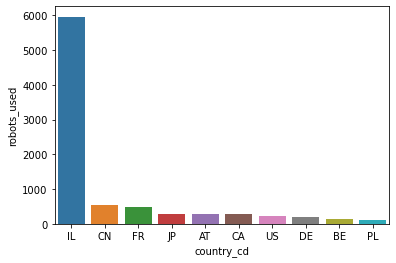

In [7]:
# Graph displays top 10 countries according to number of robots used
sns.barplot(x="country_cd", y="robots_used", data=country_robotusers)

 From the above graph we can say that IL- Israel has the most number of robots followed by CN, FR, JP,...

### From here on, we will focus on the top 10 countries market and understand the usage patterns in these regions, which we can use to design marketing and business strategies.

In [8]:
# Let's focus on the top 10 countries now to get a good idea of the market there.
robotmissiontop10_df = robotmission_df[robotmission_df['country_cd'].isin(country_robotusers['country_cd'].tolist())]
df2 = robotmissiontop10_df[robotmissiontop10_df['outcome'].notnull()]
df2.head(10)

,robotid,datetime,nmssn,runm,chrgm,pausem,outcome,country_cd,timezone
0,000NG2FMLJBT9ANZ,10/1/17 16:17,40.0,3.0,1.0,2.0,stuck,IL,Asia/Jerusalem
1,000NG2FMLJBT9ANZ,10/3/17 14:25,41.0,83.0,0.0,13.0,ok,IL,Asia/Jerusalem
2,000NG2FMLJBT9ANZ,10/4/17 12:32,42.0,66.0,13.0,12.0,ok,IL,Asia/Jerusalem
3,000NG2FMLJBT9ANZ,10/26/17 2:12,45.0,72.0,24.0,0.0,cncl,IL,Asia/Jerusalem
4,000NG2FMLJBT9ANZ,10/27/17 7:17,46.0,61.0,9.0,0.0,cncl,IL,Asia/Jerusalem
5,000Y9NBMJ77LQ7S7,11/28/16 5:41,55.0,61.0,0.0,13.0,ok,JP,Asia/Tokyo
6,000Y9NBMJ77LQ7S7,12/20/16 10:06,56.0,31.0,0.0,6.0,cncl,JP,Asia/Tokyo
7,000Y9NBMJ77LQ7S7,2/18/17 3:16,57.0,11.0,0.0,2.0,cncl,JP,Asia/Tokyo
8,000Y9NBMJ77LQ7S7,3/8/17 10:49,58.0,78.0,0.0,0.0,ok,JP,Asia/Tokyo
9,000Y9NBMJ77LQ7S7,3/19/17 10:21,59.0,99.0,0.0,0.0,cncl,JP,Asia/Tokyo


In [9]:
# Missions recorded Countrywise
missions = df2.groupby('country_cd').outcome.count().reset_index()
missions = missions.rename(columns={'outcome':'total_missions'})
missions.head(10)

,country_cd,total_missions
0,AT,10558
1,BE,5123
2,CA,11126
3,CN,21054
4,DE,8284
5,FR,17719
6,IL,220119
7,JP,11743
8,PL,4388
9,US,8221


### Summary of mission outcomes in percentages in the top 10 robot used countries

In [10]:
df2.groupby('country_cd').outcome.value_counts(normalize=True)*100

country_cd  outcome
AT          ok         61.678348
            cncl       28.603902
            stuck       7.340405
            bat         2.377344
BE          ok         61.311731
            cncl       29.299239
            stuck       7.124732
            bat         2.264298
CA          ok         62.043861
            cncl       28.168255
            stuck       7.693690
            bat         2.094194
CN          ok         65.935214
            cncl       28.241664
            stuck       3.704759
            bat         2.118362
DE          ok         61.528247
            cncl       29.792371
            stuck       6.542733
            bat         2.136649
FR          ok         62.210057
            cncl       27.800666
            stuck       7.889836
            bat         2.099441
IL          cncl       47.570632
            ok         44.505926
            stuck       5.435696
            bat         2.487745
JP          ok         61.185387
            cncl       

### We see that in IL, 47.57% of the robot missions recorded have been cancelled by the user and only 44.5% were successfully completed. While in other countries, the cancellation percent is relatively low and success rate is high. We can see a geographical difference here in IL and need to investigate into this problem. Also, we see that in CN, only 3.7% of the missions ended up stuck on an obstacle, which is low as compared to other countries thus indicating there were very few navigation problems in the CN market. Also, we can see that in CN, 65% of robot missions have been successfully completed which is a good number and indicates that robots have been performing to a good extent in CN.

### Charging Time Issues

In [11]:
df2.groupby('country_cd').describe()['chrgm'].reset_index()

,country_cd,count,mean,std,min,25%,50%,75%,max
0,AT,10558.0,1.930100,5.059244,0.0,0.0,0.0,0.0,23.0
1,BE,5123.0,2.094085,5.218136,0.0,0.0,0.0,0.0,23.0
2,CA,11126.0,1.969081,5.063226,0.0,0.0,0.0,0.0,23.0
3,CN,21054.0,1.905861,5.004199,0.0,0.0,0.0,0.0,24.0
4,DE,8284.0,1.917190,5.051960,0.0,0.0,0.0,0.0,24.0
5,FR,17719.0,3.176534,6.335931,0.0,0.0,0.0,0.0,24.0
6,IL,220119.0,7.200628,9.376880,0.0,0.0,0.0,15.0,30.0
7,JP,11743.0,1.977178,5.111330,0.0,0.0,0.0,0.0,24.0
8,PL,4388.0,2.106427,5.325539,0.0,0.0,0.0,0.0,23.0
9,US,8221.0,1.952074,5.054774,0.0,0.0,0.0,0.0,23.0


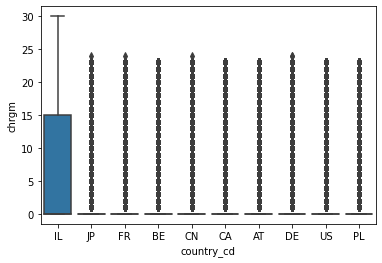

In [12]:
sns.boxplot(x='country_cd',y='chrgm',data=df2)

From the above plot, we can say that robots in Israel are facing battery issues, as in it consumes time charging.

### Run Time

In [13]:
df2.groupby('country_cd').describe()['runm'].reset_index()

,country_cd,count,mean,std,min,25%,50%,75%,max
0,AT,10558.0,47.184978,31.296090,0.0,21.0,45.0,71.0,119.0
1,BE,5123.0,47.606090,31.126517,0.0,22.0,46.0,72.0,119.0
2,CA,11126.0,47.812062,31.147565,0.0,21.0,46.0,72.0,119.0
3,CN,21054.0,40.208891,24.472748,0.0,23.0,38.0,55.0,119.0
4,DE,8284.0,47.309271,31.025146,0.0,21.0,45.0,71.0,119.0
5,FR,17719.0,46.923811,30.625854,0.0,21.0,45.0,70.0,120.0
6,IL,220119.0,50.555186,29.277397,0.0,30.0,49.0,70.0,144.0
7,JP,11743.0,47.485821,31.330961,0.0,21.0,45.0,71.0,119.0
8,PL,4388.0,47.620328,31.375072,0.0,20.0,46.0,72.0,119.0
9,US,8221.0,47.559421,31.134420,0.0,21.0,46.0,72.0,119.0


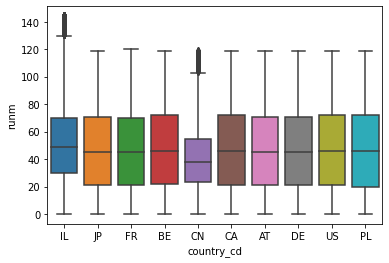

In [14]:
sns.boxplot(x='country_cd',y='runm',data=df2)

From the above plot, we can see that the robot missions in China have less run time as compared to the other countries. This could be owing to the houses in China having small spaces and thus takes less time to clean.

### Pause Time

In [15]:
df2.groupby('country_cd').describe()['pausem'].reset_index()

,country_cd,count,mean,std,min,25%,50%,75%,max
0,AT,10558.0,4.572362,6.406180,0.0,0.0,0.0,9.0,21.0
1,BE,5123.0,4.697833,6.494347,0.0,0.0,0.0,9.0,21.0
2,CA,11126.0,4.726496,6.538616,0.0,0.0,0.0,9.0,21.0
3,CN,21054.0,0.696210,2.861377,0.0,0.0,0.0,0.0,19.0
4,DE,8284.0,4.663206,6.425742,0.0,0.0,0.0,9.0,21.0
5,FR,17719.0,4.728145,6.555706,0.0,0.0,0.0,9.0,21.0
6,IL,220119.0,7.659630,8.998813,0.0,0.0,4.0,14.0,40.0
7,JP,11743.0,4.620114,6.476471,0.0,0.0,0.0,9.0,21.0
8,PL,4388.0,4.690520,6.524763,0.0,0.0,0.0,9.0,21.0
9,US,8221.0,4.678020,6.522660,0.0,0.0,0.0,9.0,21.0


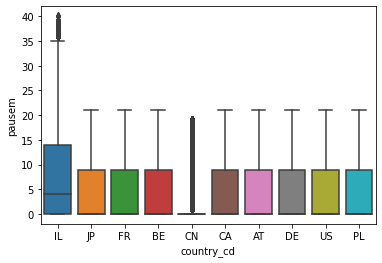

In [16]:
sns.boxplot(x='country_cd',y='pausem',data=df2)

From the above plot,we can see that only few robots in China are paused which are clearly the outliers. We can also say from here that navigation issues are not much faced in China. While in IL, we can clearly say that there is a high pause time in each of the missions, thus indicating navigation problems.

### Total Number of Missions - How frequent do the missions occur in different countries?

In [17]:
df3 = df2.groupby(['robotid','country_cd']).max()['nmssn'].reset_index()
df3.head()

,robotid,country_cd,nmssn
0,000NG2FMLJBT9ANZ,IL,46.0
1,000Y9NBMJ77LQ7S7,JP,61.0
2,006Q50H53GXM7BYO,IL,64.0
3,00EZQ4MZ6JLQPJK6,FR,129.0
4,00KI1HU70Y15Z10K,BE,108.0


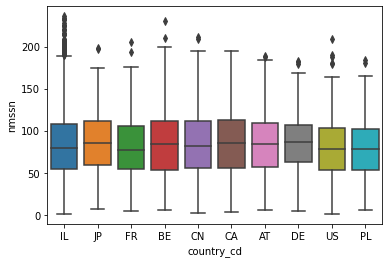

In [18]:
sns.boxplot(x='country_cd',y='nmssn',data=df3)

In [19]:
df2['new_date'] = pd.to_datetime(df2['datetime'])
df2['month'] = df2.new_date.dt.month
df2['year'] = df2.new_date.dt.year
df2['quarter'] = ['Q1' if item in (1,2,3) else 'Q2' if item in (4,5,6) else 'Q3' if item in (7,8,9) else 'Q4' for item in df2['month']]
df2.head()

,robotid,datetime,nmssn,runm,chrgm,pausem,outcome,country_cd,timezone,new_date,month,year,quarter
0,000NG2FMLJBT9ANZ,10/1/17 16:17,40.0,3.0,1.0,2.0,stuck,IL,Asia/Jerusalem,2017-10-01 16:17:00,10,2017,Q4
1,000NG2FMLJBT9ANZ,10/3/17 14:25,41.0,83.0,0.0,13.0,ok,IL,Asia/Jerusalem,2017-10-03 14:25:00,10,2017,Q4
2,000NG2FMLJBT9ANZ,10/4/17 12:32,42.0,66.0,13.0,12.0,ok,IL,Asia/Jerusalem,2017-10-04 12:32:00,10,2017,Q4
3,000NG2FMLJBT9ANZ,10/26/17 2:12,45.0,72.0,24.0,0.0,cncl,IL,Asia/Jerusalem,2017-10-26 02:12:00,10,2017,Q4
4,000NG2FMLJBT9ANZ,10/27/17 7:17,46.0,61.0,9.0,0.0,cncl,IL,Asia/Jerusalem,2017-10-27 07:17:00,10,2017,Q4


### Quarterly Robot Missions carried out

In [20]:
df2.groupby('country_cd').quarter.value_counts(normalize=True)*100

country_cd  quarter
AT          Q3         29.702595
            Q4         28.963819
            Q2         23.991286
            Q1         17.342300
BE          Q4         31.719695
            Q3         27.366777
            Q2         23.072419
            Q1         17.841109
CA          Q4         32.716160
            Q3         29.273773
            Q2         23.099047
            Q1         14.911019
CN          Q4         29.965802
            Q3         27.728698
            Q2         23.558469
            Q1         18.747031
DE          Q4         33.944954
            Q3         25.941574
            Q2         21.209561
            Q1         18.903911
FR          Q4         30.120210
            Q3         29.984762
            Q2         22.450477
            Q1         17.444551
IL          Q4         31.357584
            Q3         28.001672
            Q2         23.390530
            Q1         17.250215
JP          Q3         29.813506
            Q4         

### We see that most of the robot missions were carried out during the 4th quarter (Oct-Nov-Dec) and least robot missions were carried out during 1st quarter, indicating that there is a high usage during the 3rd and 4th quarter and relatively low during the 1st and 2nd. However, many missions have not been recorded in the database so there is a data loss, due to which we do not get a great understanding of this quarter division. But if this is true, then we can do a lot of marketing in the 3rd or 4th quarter.